In [1]:
!pip install qulacs

In [1]:
import numpy as np
from qulacs import ParametricQuantumCircuit, QuantumState
from qulacs.state import inner_product
from cvxopt import matrix, solvers

# データセットの生成
下図のトポロジーを考える
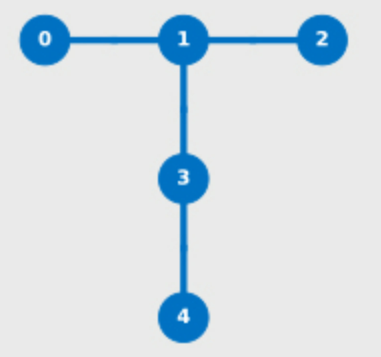
スタビライザー群は
$$
 S_{graph} = \langle \{ X_{i} \otimes_{k:(k,i)\in E} Z_{k} \}_{i\in V} \rangle
$$
なので上記T型のトポロジーの場合、生成元はXZIII, ZXZZI, IZXII, IZIXZ, IIIZXとなる

In [2]:
n_qubits = 5

# 用いるスタビライザー群の要素を決定する
S = np.zeros((n_qubits, 2*n_qubits))
S[0] = np.array([1,0, 0,1, 0,0, 0,0, 0,0]) # XZIII (X->1,0 Z->0,1 I->0,0としてならべる)
S[1] = np.array([0,1, 1,0, 0,1, 0,1, 0,0]) # ZXZZI
S[2] = np.array([0,0, 0,1, 1,0, 0,0, 0,0]) # IZXII
S[3] = np.array([0,0, 0,1, 0,0, 1,0, 0,1]) # IZIXZ
S[4] = np.array([0,0, 0,0, 0,0, 0,1, 1,0]) # IIIZX

def x_generator(c):
    SS = np.copy(S)

    select = np.random.randint(0,2,n_qubits) # i番目の生成元を使う(1)か使わない(0)かを決める行列
    for i in range(n_qubits):
        SS[i] = SS[i] * select[i]
    op = np.sum(SS, axis=0) # それぞれのビットにそれぞれのゲート(X, Z)が何回掛かるかを示す行列

    # \theta_{+-}を計算する
    theta = np.zeros(2*n_qubits)

    for i in range(n_qubits):
        theta[2*i] = c[2*i] + np.pi/2 * op[2*i]
        theta[2*i+1] = (-1)**op[2*i] * c[2*i+1] + np.pi/2 * op[2*i+1]

    for i in range(2*n_qubits): # 0～\piの値にする
        theta[i] = theta[i] % np.pi
    
    return theta

In [3]:
n_data_train = 50
epsilon = 0.0 # エラーの分散
e = np.random.normal(0, np.sqrt(epsilon), (2*n_data_train, 2*n_qubits))

# c_{+-}を決める
c_plus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4 # - \pi/4 ～ \pi/4 のランダムな数
c_minus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4

x_plus = x_generator(c_plus).reshape((1,-1))
x_minus = x_generator(c_minus).reshape((1,-1))
for i in range(n_data_train-1):
    xx = x_generator(c_plus).reshape((1,-1))
    x_plus = np.concatenate([x_plus, xx])
    xx = x_generator(c_minus).reshape((1,-1))
    x_minus = np.concatenate([x_minus, xx])
x_train = np.concatenate([x_plus, x_minus]) + e

y_plus = np.ones(n_data_train)
y_minus = -np.ones(n_data_train)
y_train = np.concatenate([y_plus, y_minus]).reshape(1,-1)
print(x_train)
print(y_train)

[[1.57170791e+00 1.50973201e+00 2.22256687e+00 6.39880735e-01
  5.25762079e-01 1.98569947e+00 1.45256494e+00 1.27472927e+00
  1.86516444e-01 2.07130281e+00]
 [1.57170791e+00 1.50973201e+00 2.22256687e+00 2.21067706e+00
  5.25762079e-01 1.98569947e+00 3.02336127e+00 1.86686338e+00
  1.86516444e-01 5.00506479e-01]
 [9.11578330e-04 1.63186064e+00 2.22256687e+00 6.39880735e-01
  5.25762079e-01 1.98569947e+00 3.02336127e+00 1.86686338e+00
  1.86516444e-01 5.00506479e-01]
 [9.11578330e-04 6.10643143e-02 6.51770541e-01 9.30915592e-01
  5.25762079e-01 4.14903146e-01 1.45256494e+00 1.27472927e+00
  1.75731277e+00 1.07028985e+00]
 [9.11578330e-04 1.63186064e+00 2.22256687e+00 2.21067706e+00
  2.09655841e+00 1.15589318e+00 3.02336127e+00 2.96067056e-01
  1.75731277e+00 2.64108617e+00]
 [9.11578330e-04 6.10643143e-02 6.51770541e-01 9.30915592e-01
  2.09655841e+00 2.72668951e+00 3.02336127e+00 1.86686338e+00
  1.75731277e+00 2.64108617e+00]
 [1.57170791e+00 3.08052834e+00 6.51770541e-01 9.30915592e

回路の作成
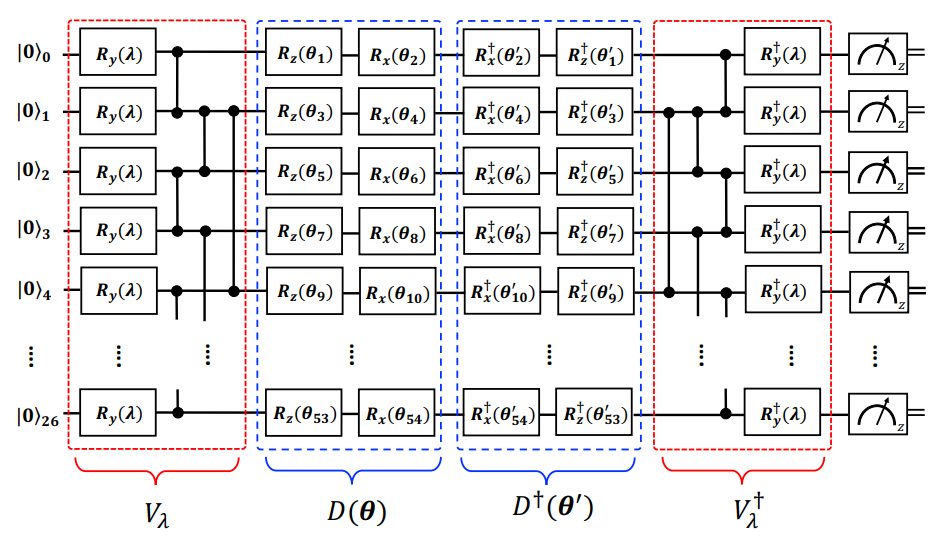

In [4]:
# D_x V_\lambda |0> を生成する回路
def kernel_circuit(lam, x):
    circuit = ParametricQuantumCircuit(n_qubits)
    # V
    for i in range(n_qubits):
        circuit.add_parametric_RY_gate(i, lam[i])
    # T型のトポロジー
    circuit.add_CZ_gate(0,1)
    circuit.add_CZ_gate(1,2)
    circuit.add_CZ_gate(1,3)
    circuit.add_CZ_gate(3,4)

    # D
    for i in range(n_qubits):
        circuit.add_RZ_gate(i, x[2*i])
        circuit.add_RX_gate(i, x[2*i+1])
    
    return circuit

# カーネルの計算
def kernel_entry(x1, x2, lam):
    state1 = QuantumState(n_qubits)
    state2 = QuantumState(n_qubits)
    
    state1.set_zero_state()
    state2.set_zero_state()
    
    circuit1 = kernel_circuit(lam, x1)
    circuit2 = kernel_circuit(lam, x2)
    
    circuit1.update_quantum_state(state1)
    circuit2.update_quantum_state(state2)
    
    return abs(inner_product(state1, state2)) ** 2

グラム行列の計算

In [5]:
def gram(lam, x):
    gram_matrix = np.ones([2*n_data_train, 2*n_data_train])
    # グラム行列計算(対角成分は1で転置しても値が変わらないという対照性を用いて計算量を減らした)
    for i in range(2*n_data_train-1):
        for j in range(i+1):
            kernel = kernel_entry(x[i+1],x[j], lam)
            gram_matrix[i+1,j] = kernel
            gram_matrix[j,i+1] = kernel
    return gram_matrix

最適化
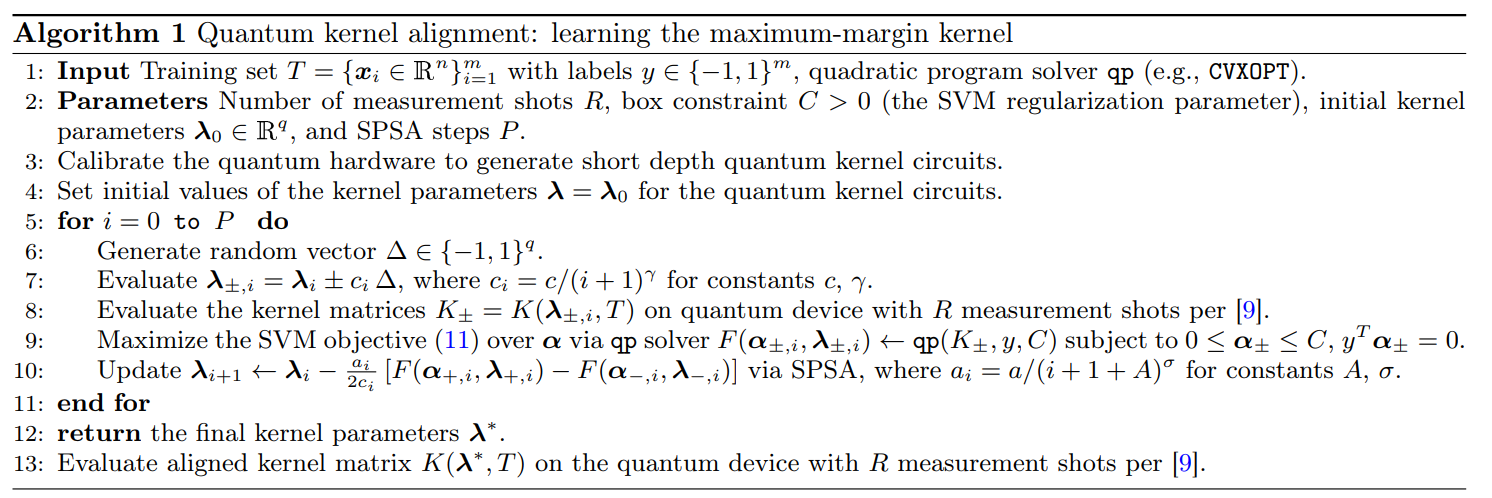

In [6]:
C = 1 # box parameter (論文には0以上の任意の値と書いてあるが、どんな値にすればよいかわからん)
P = 20 # SPSAの回数
b = 1 # 論文Algorithm 1中のc（定数とだけ書いてあるが、どんな値にすればよいかわからん）
gamma = 1 # 論文Algorithm 1中の\gamma（定数とだけ書いてあるが、どんな値にすればよいかわからん）
a = 1
A = 1
sigma = 1

lam_initial = 1.0 # \lambdaの初期値
lam_history = []
F_history = []
K_history = []
alpha_history = []

lam0 = lam_initial
for i in range(P):
    lam = np.full(n_qubits, lam0)
    b_i = np.full(n_qubits, b / (i + 1) ** gamma)
    a_i = np.full(n_qubits, a / (i + 1 + A) ** sigma)
    # 6行目
    Delta = 2*np.random.randint(0, 2, n_qubits) - 1 # ランダムに{-1, 1}を生成
    # 7行目
    lam_plus = lam + b_i * Delta
    lam_minus = lam - b_i * Delta
    # 8行目
    K = gram(lam, x_train)
    K_plus = gram(lam_plus, x_train)
    K_minus = gram(lam_minus, x_train)
    # 9行目(cvxoptを用いるためにいろんな計算をしている)
    Y = y_train.T @ y_train
    P = Y * K
    P_cvx = matrix(P)
    P_plus = Y * K_plus
    P_plus_cvx = matrix(P_plus)
    P_minus = Y * K_minus
    P_minus_cvx = matrix(P_minus)
    q = -np.ones(2*n_data_train).T
    q_cvx = matrix(q)
    G = matrix(np.identity(2*n_data_train))
    h = matrix(np.zeros(2*n_data_train))
    AA = matrix(y_train)
    bb = matrix(0.0)
    sol = solvers.qp(P_cvx, q_cvx, G, h, AA, bb)
    sol_plus = solvers.qp(P_plus_cvx, q_cvx, G, h, AA, bb)
    sol_minus = solvers.qp(P_minus_cvx, q_cvx, G, h, AA, bb)
    alpha = np.array(sol['x']).reshape(-1)
    alpha_plus = np.array(sol_plus['x']).reshape(-1)
    alpha_minus = np.array(sol_minus['x']).reshape(-1)
    # 10行目
    F = -q @ alpha + 1/2 * alpha.T @ P @ alpha
    F_plus = -q @ alpha_plus + 1/2 * alpha_plus.T @ P_plus @ alpha_plus
    F_minus = -q @ alpha_minus + 1/2 * alpha_minus.T @ P_minus @ alpha_minus
    lam0 -= a_i[0]/(2*b_i[0]) * (F_plus - F_minus)
    # データの保存
    lam_history.append(lam0)
    F_history.append(F)
    K_history.append(K)
    alpha_history.append(alpha)

     pcost       dcost       gap    pres   dres
 0: -3.2123e+01  3.3563e+01  2e+02  2e+01  1e+00
 1:  1.0919e+01 -9.0879e-01  2e+01  6e-01  3e-02
 2:  6.2471e-01 -4.3144e-03  7e-01  1e-02  5e-04
 3:  6.8617e-03 -5.4743e-07  8e-03  1e-04  5e-06
 4:  6.8613e-05 -5.4745e-11  8e-05  1e-06  5e-08
 5:  6.8613e-07 -5.4745e-15  8e-07  1e-08  5e-10
 6:  6.8613e-09 -5.4745e-19  8e-09  1e-10  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2850e+01 -9.4940e+00  6e+01  2e+01  4e-16
 1: -1.6642e+01 -4.8180e+00  7e+00  3e+00  4e-16
 2: -7.1020e+00 -9.8311e-01  6e+00  2e+00  5e-16
 3:  3.4810e-01 -9.2855e-03  2e+00  1e-01  2e-15
 4:  9.3208e-03 -1.4881e-05  3e-02  2e-03  5e-16
 5:  9.3454e-05 -1.5023e-09  3e-04  2e-05  2e-16
 6:  9.3453e-07 -1.5023e-13  3e-06  2e-07  3e-16
 7:  9.3453e-09 -1.5023e-17  3e-08  2e-09  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0431e+01 -7.4316e+00  1e+02  2e+01  1e-15
 1: -1.7316e+01 -2.3410e

     pcost       dcost       gap    pres   dres
 0: -3.2123e+01  3.3563e+01  2e+02  2e+01  1e+00
 1:  1.0919e+01 -9.0879e-01  2e+01  6e-01  3e-02
 2:  6.2471e-01 -4.3144e-03  7e-01  1e-02  5e-04
 3:  6.8617e-03 -5.4743e-07  8e-03  1e-04  5e-06
 4:  6.8613e-05 -5.4745e-11  8e-05  1e-06  5e-08
 5:  6.8613e-07 -5.4745e-15  8e-07  1e-08  5e-10
 6:  6.8613e-09 -5.4745e-19  8e-09  1e-10  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2823e+01 -9.8356e+00  6e+01  2e+01  4e-16
 1: -1.8782e+01 -5.2529e+00  1e+01  5e+00  3e-16
 2: -5.6948e+00 -9.5329e-01  8e+00  2e+00  4e-16
 3:  1.5893e+00 -5.8387e-02  2e+00  4e-02  9e-16
 4:  4.9359e-02 -1.9081e-04  6e-02  7e-04  3e-16
 5:  5.0431e-04 -2.0425e-08  6e-04  7e-06  3e-16
 6:  5.0429e-06 -2.0426e-12  6e-06  7e-08  3e-16
 7:  5.0429e-08 -2.0426e-16  6e-08  7e-10  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1836e+01  3.4647e+01  2e+02  2e+01  1e+00
 1:  1.1712e+01 -1.0441e

     pcost       dcost       gap    pres   dres
 0: -3.2123e+01  3.3563e+01  2e+02  2e+01  1e+00
 1:  1.0919e+01 -9.0879e-01  2e+01  6e-01  3e-02
 2:  6.2471e-01 -4.3144e-03  7e-01  1e-02  5e-04
 3:  6.8617e-03 -5.4743e-07  8e-03  1e-04  5e-06
 4:  6.8613e-05 -5.4745e-11  8e-05  1e-06  5e-08
 5:  6.8613e-07 -5.4745e-15  8e-07  1e-08  5e-10
 6:  6.8613e-09 -5.4745e-19  8e-09  1e-10  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2062e+01  3.3776e+01  2e+02  2e+01  1e+00
 1:  1.1074e+01 -9.4872e-01  2e+01  6e-01  3e-02
 2:  6.3031e-01 -4.3998e-03  7e-01  9e-03  5e-04
 3:  6.9280e-03 -5.5966e-07  8e-03  9e-05  5e-06
 4:  6.9276e-05 -5.5968e-11  8e-05  9e-07  5e-08
 5:  6.9276e-07 -5.5968e-15  8e-07  9e-09  5e-10
 6:  6.9276e-09 -5.5968e-19  8e-09  9e-11  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2239e+01  3.3146e+01  2e+02  2e+01  1e+00
 1:  1.0632e+01 -8.4260e-01  2e+01  6e-01  3e-02
 2:  6.0055e-01 -3.9384e

In [7]:
print(F_history)
print(lam_history)

[-6.861266332153509e-09, -6.861266318341967e-09, -6.8612663160082675e-09, -6.861266309622709e-09, -6.8612663138552685e-09, -6.86126628125016e-09, -6.861266280134824e-09, -6.861266101082003e-09, -6.8612659902809634e-09, -6.8612659714765954e-09, -6.861265968809621e-09, -6.861265976222708e-09, -6.861265938971204e-09, -6.861265936672381e-09, -6.8612659428429395e-09, -6.861265941782132e-09, -6.861265915611358e-09, -6.861265910738617e-09, -6.861265869291848e-09, -6.861265866541088e-09]
[1.0000000023255902, 1.000000002718283, 1.0000000037935517, 1.0000000030808507, 1.0000000085706477, 1.0000000087585204, 1.000000038905944, 1.0000000575617836, 1.0000000607279098, 1.0000000611769486, 1.0000000599288146, 1.000000066200937, 1.0000000665880149, 1.000000065549029, 1.0000000657277743, 1.0000000701339997, 1.0000000709544783, 1.0000000779330658, 1.0000000783962306, 1.0000000772635924]


# テストデータ生成

In [8]:
n_data_test = 10
epsilon = 0.0 # エラーの分散
e = np.random.normal(0, np.sqrt(epsilon), (2*n_data_test, 2*n_qubits))

x_plus = x_generator(c_plus).reshape((1,-1))
x_minus = x_generator(c_minus).reshape((1,-1))
for i in range(n_data_test-1):
    xx = x_generator(c_plus).reshape((1,-1))
    x_plus = np.concatenate([x_plus, xx])
    xx = x_generator(c_minus).reshape((1,-1))
    x_minus = np.concatenate([x_minus, xx])
x_test = np.concatenate([x_plus, x_minus]) + e

y_plus = np.ones(n_data_test)
y_minus = -np.ones(n_data_test)
y_test = np.concatenate([y_plus, y_minus]).reshape(1,-1)
print(y_test)

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.]]


# テストデータの分類

In [9]:
f = np.zeros(2*n_data_test)
for i in range(2*n_data_test):
    z = x_test[i]
    K2 = np.zeros((1,2*n_data_train))
    for j in range(2*n_data_train):
        K2[:,j] = kernel_entry(x_train[j], z, np.full(n_qubits, lam_history[-1]))
    ff = y_train * alpha_history[-1] * K2
    f[i] = np.sign(np.sum(ff))
print(f)
print(y_test)
print((f-y_test)/2)

[-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.
 -1.  1.]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1.]]
[[-1. -1.  0. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  0.  1.  0.  1.
   0.  1.]]


# トレーニングデータでの確認

In [10]:
f = np.zeros(2*n_data_train)
for i in range(2*n_data_train):
    z = x_train[i]
    K2 = np.zeros((1,2*n_data_train))
    for j in range(2*n_data_train):
        K2[:,j] = kernel_entry(x_train[j], z, np.full(n_qubits, lam_history[-1]))
    ff = y_train * alpha_history[-1] * K2
    f[i] = np.sign(np.sum(ff))
print(f)
print(y_train)
print((f-y_train)/2)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1.
  -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -